# dask.dataframe

<img src="https://github.com/ualberta-rcg/python-dask/blob/master/notebooks/assets/dask-dataframe.svg?raw=1"
     align="right"
     width="20%"
     alt="Dask dataframes are blocked Pandas dataframes">
     
Dask Dataframes coordinate many Pandas dataframes, partitioned along an index.  They support a large subset of the Pandas API.

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [ ]:
# NOTE!!! Don't do this on Colab

from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

## Create Random Dataframe

In [ ]:
# In order for the following mock datasets to work, we may need to install this further dependency.
# Uncomment the needed line ...

# !pip install fsspec
# !conda install fsspec

We create a random timeseries of data with the following attributes:

1.  It stores a record for every 1 second of the first month of 2000
2.  Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset (each day is about 6MB, for a total of 180MB). Increase the number of days or reduce the frequency to practice with a larger dataset.

We'll dump this mock data into files (one per day)

In [1]:
import os

if not os.path.exists('data'):
    os.mkdir('data')

import dask
import datetime

ts = dask.datasets.timeseries()

name = lambda i:str(datetime.date(2000, 1, 1) + i * datetime.timedelta(days=1))

ts.to_csv('data/*.csv', name_function=name);

/usr/local/lib/python3.11/dist-packages/dask_expr/_collection.py:6004: UserWarning: dask_expr does not support the DataFrameIOFunction protocol for column projection. To enable column projection, please ensure that the signature of `func` includes a `columns=` keyword argument instead.
  warnings.warn(


In [2]:
# If you want to know more about this function to create fake data

help(dask.datasets.timeseries)

Help on function timeseries in module dask.datasets:

timeseries(start='2000-01-01', end='2000-01-31', freq='1s', partition_freq='1D', dtypes=None, seed=None, **kwargs)
    Create timeseries dataframe with random data
    
    Parameters
    ----------
    start : datetime (or datetime-like string)
        Start of time series
    end : datetime (or datetime-like string)
        End of time series
    dtypes : dict (optional)
        Mapping of column names to types.
        Valid types include {float, int, str, 'category'}
    freq : string
        String like '2s' or '1H' or '12W' for the time series frequency
    partition_freq : string
        String like '1M' or '2Y' to divide the dataframe into partitions
    seed : int (optional)
        Randomstate seed
    kwargs:
        Keywords to pass down to individual column creation functions.
        Keywords should be prefixed by the column name and then an underscore.
    
    Examples
    --------
    >>> import dask
    >>> df = da

In [3]:
# These will work on Mac or Linux

!ls data/*.csv

!head data/2000-01-01.csv

data/2000-01-01.csv  data/2000-01-09.csv  data/2000-01-17.csv  data/2000-01-25.csv
data/2000-01-02.csv  data/2000-01-10.csv  data/2000-01-18.csv  data/2000-01-26.csv
data/2000-01-03.csv  data/2000-01-11.csv  data/2000-01-19.csv  data/2000-01-27.csv
data/2000-01-04.csv  data/2000-01-12.csv  data/2000-01-20.csv  data/2000-01-28.csv
data/2000-01-05.csv  data/2000-01-13.csv  data/2000-01-21.csv  data/2000-01-29.csv
data/2000-01-06.csv  data/2000-01-14.csv  data/2000-01-22.csv  data/2000-01-30.csv
data/2000-01-07.csv  data/2000-01-15.csv  data/2000-01-23.csv
data/2000-01-08.csv  data/2000-01-16.csv  data/2000-01-24.csv
timestamp,name,id,x,y
2000-01-01 00:00:00,Edith,984,-0.4340468057422404,-0.5151187345128907
2000-01-01 00:00:01,Frank,995,-0.9939937477112384,0.92828928902152
2000-01-01 00:00:02,Oliver,1002,-0.9846575304724183,0.33865655096089986
2000-01-01 00:00:03,Charlie,988,-0.34512600947980543,0.2965642512026627
2000-01-01 00:00:04,Tim,1039,-0.8082284187137172,-0.48249458396355704
2000-

Now we will load the csv files. Unlike Pandas, dask understands a wildcard * in a filename.

In [4]:
import dask.dataframe as dd

df = dd.read_csv('data/2000-*-*.csv')

# Unlike Pandas, Dask DataFrames are lazy and so no data is printed here.
df

,timestamp,name,id,x,y
npartitions=30,,,,,
,string,string,int64,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


But the column names and dtypes are known.

In [5]:
df.dtypes

,0
timestamp,string[pyarrow]
name,string[pyarrow]
id,int64
x,float64
y,float64


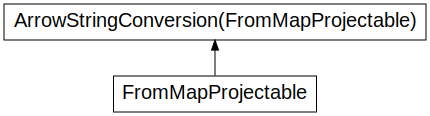

In [6]:
df.visualize()

Some operations will automatically display the data.

In [7]:
df.head(3)

,timestamp,name,id,x,y
0,2000-01-01 00:00:00,Edith,984,-0.434047,-0.515119
1,2000-01-01 00:00:01,Frank,995,-0.993994,0.928289
2,2000-01-01 00:00:02,Oliver,1002,-0.984658,0.338657


## Use Standard Pandas Operations

Most common Pandas operations operate identically on Dask dataframes

In [8]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: getitem, 8 expressions
Expr=(((Filter(frame=ArrowStringConversion(frame=FromMapProjectable(6242bf6)), predicate=ArrowStringConversion(frame=FromMapProjectable(6242bf6))['y'] > 0))[['name', 'x']]).std(ddof=1, numeric_only=False, split_out=None, observed=False))['x']

Call `.compute()` when you want your result as a Pandas dataframe.

If you started `Client()` above then you may want to watch the status page during computation.

In [9]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [10]:
computed_df

,x
name,
Bob,0.577208
Dan,0.577640
Edith,0.578059
George,0.577237
Hannah,0.578278
Ingrid,0.576515
Laura,0.575322
Michael,0.578273
Quinn,0.577213


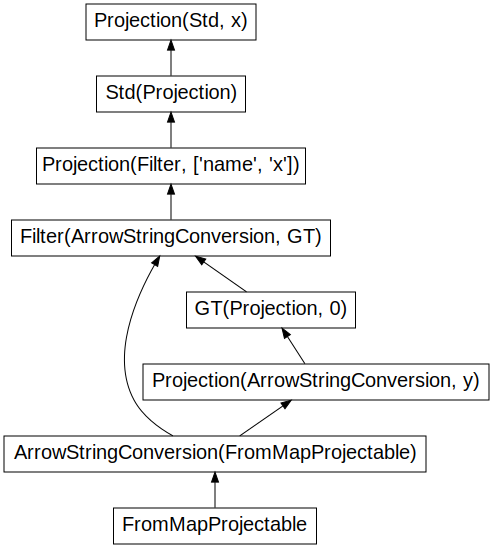

In [11]:
df3.visualize()

## Exercise:

* Find the mean x value for all people named Alice
* Sum the id numbers for all people named Tim

(Note: these are really just Pandas exercises, the fact that we are using Dask is mostly transparent.)

[On to the next notebook (`dask.bag`)](06-bag.ipynb) ...

In [15]:
df4 = df[df['name'] == 'Alice'].x.std()
result = df4.compute()
result

np.float64(0.5761024108256243)

In [16]:
df5 = df[df['name'] == "Tim"].id.sum()
result = df5.compute()
result

np.int64(99072425)